# Multi-controlled Rx rotation gate decompositions

In [5]:
import numpy as np
import networkx as nx
import qiskit
from qiskit import Aer

import qcopt

from NuOp import gates_numpy
from NuOp import parallel_two_qubit_gate_decomposition as nuop

import gate_decomposition_numerics as gdn
import matplotlib.pyplot as plt

## Comparing gate decompositions on large graphs

In [6]:
for size in [10, 100, 1000]:
    #G = gdn.gen_erdos_renyi_graph(size, 0.1)
    G = gdn.gen_3_regular_graph(size)
    avg_density = np.mean([t[1] for t in G.degree()])
    print(size, "node graphs, average density:", avg_density)

    sa_qaoa_gate_count = gdn.sa_qaoa_gate_count(G, 10)
    print('\tSA-QAOA:')
    for n in [1,2]:
        one_ancilla_count = gdn.one_ancilla_barenco(sa_qaoa_gate_count, n)
        n_ancilla_count = gdn.n_ancilla_barenco(sa_qaoa_gate_count, n)
        print(f'\t\tWith native C_{n}_X: {one_ancilla_count} w/one ancilla, {n_ancilla_count} w/n ancilla')

    ma_qaoa_gate_count = gdn.ma_qaoa_gate_count(G)
    print('\tMA-QAOA:')
    for n in [1,2]:
        one_ancilla_count = gdn.one_ancilla_barenco(ma_qaoa_gate_count, n)
        n_ancilla_count = gdn.n_ancilla_barenco(ma_qaoa_gate_count, n)
        print(f'\t\tWith native C_{n}_X: {one_ancilla_count} w/one ancilla, {n_ancilla_count} w/n ancilla')

    dqva_gate_count = gdn.dqva_gate_count(G, size // 2)
    print('\tDQVA:')
    for n in [1,2]:
        one_ancilla_count = gdn.one_ancilla_barenco(dqva_gate_count, n)
        n_ancilla_count = gdn.n_ancilla_barenco(dqva_gate_count, n)
        print(f'\t\tWith native C_{n}_X: {one_ancilla_count} w/one ancilla, {n_ancilla_count} w/n ancilla')

    print()


10 node graphs, average density: 3.0
	SA-QAOA:
		With native C_1_X: 6800 w/one ancilla, 1800 w/n ancilla
		With native C_2_X: -800 w/one ancilla, 200 w/n ancilla
	MA-QAOA:
		With native C_1_X: 680 w/one ancilla, 180 w/n ancilla
		With native C_2_X: -80 w/one ancilla, 20 w/n ancilla
	DQVA:
		With native C_1_X: 340 w/one ancilla, 90 w/n ancilla
		With native C_2_X: -40 w/one ancilla, 10 w/n ancilla

100 node graphs, average density: 3.0
	SA-QAOA:
		With native C_1_X: 68000 w/one ancilla, 18000 w/n ancilla
		With native C_2_X: -8000 w/one ancilla, 2000 w/n ancilla
	MA-QAOA:
		With native C_1_X: 6800 w/one ancilla, 1800 w/n ancilla
		With native C_2_X: -800 w/one ancilla, 200 w/n ancilla
	DQVA:
		With native C_1_X: 3400 w/one ancilla, 900 w/n ancilla
		With native C_2_X: -400 w/one ancilla, 100 w/n ancilla

1000 node graphs, average density: 3.0
	SA-QAOA:
		With native C_1_X: 680000 w/one ancilla, 180000 w/n ancilla
		With native C_2_X: -80000 w/one ancilla, 20000 w/n ancilla
	MA-QAOA:
		W

In [27]:
def plot_d3_gate_counts(sizes):
    
    fig, ax = plt.subplots(dpi=200, nrows=1, ncols=2)
    
    for alg in ['SA-QAOA', 'MA-QAOA', 'DQVA']:
        one_ancilla_decomp = []
        n_ancilla_decomp = []
        for size in sizes:
            G = gdn.gen_3_regular_graph(size)
            
            if alg == 'SA-QAOA':
                mcrx_gate_count = gdn.sa_qaoa_gate_count(G, 10)
            elif alg == 'MA-QAOA':
                mcrx_gate_count = gdn.ma_qaoa_gate_count(G)
            elif alg == 'DQVA':
                mcrx_gate_count = gdn.dqva_gate_count(G, size // 2)
            
            one_ancilla_decomp.append((gdn.one_ancilla_barenco(mcrx_gate_count, 1),
                                       gdn.one_ancilla_barenco(mcrx_gate_count, 2)))
            n_ancilla_decomp.append((gdn.n_ancilla_barenco(mcrx_gate_count, 1),
                                     gdn.n_ancilla_barenco(mcrx_gate_count, 2)))
            
        for i, native_gate in enumerate([' CX', 'CCX']):
            ls = ['-', '--']
            # Plot decomp with one ancilla
            ax[0].plot(sizes, [t[i] for t in one_ancilla_decomp], label=f'{alg}, {native_gate}', ls=ls[i])
            
            # Plot decomp with n ancilla
            ax[1].plot(sizes, [t[i] for t in n_ancilla_decomp], label=f'{alg}, {native_gate}', ls=ls[i])
    
    plt.legend()
    #ax[0].loglog()
    #ax[1].loglog()
    
    ax[0].set_title('Barenco, 1 burnable ancilla')
    ax[1].set_title(r'Barenco, $n$ burnable ancilla')
    ax[0].set_ylabel('Entangling gate count')
    ax[0].set_xlabel(r'Graph size, $n$')
    ax[1].set_xlabel(r'Graph size, $n$')
    
    plt.tight_layout()


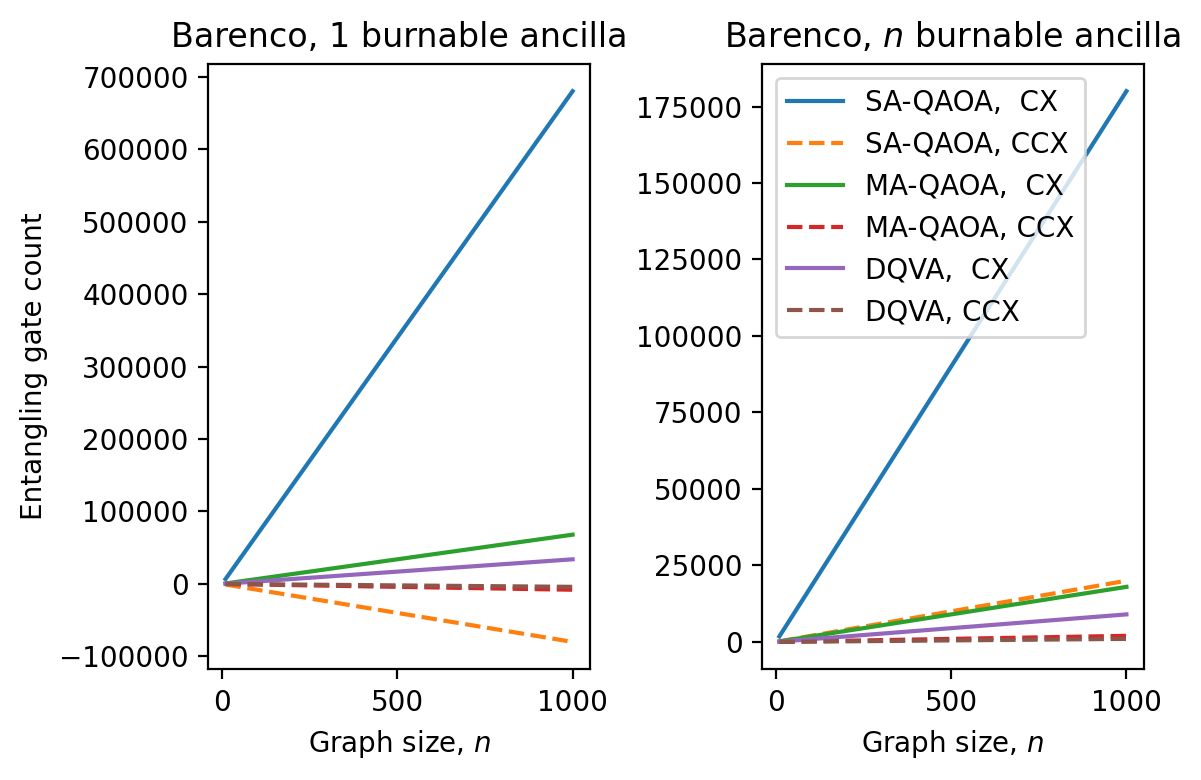

In [28]:
plot_d3_gate_counts([10,100,1000])

## No ancilla comparison

In [117]:
theta = np.pi / 2 
qubits = qiskit.QuantumRegister(4)
ancilla_circ = qiskit.QuantumCircuit(qubits)
ancilla_circ.mcrx(theta, qubits[:3], qubits[3])
ancilla_circ.measure_all()
ancilla_circ.draw(fold=-1)

┌───┐                      ┌───┐                     ┌───┐                      ┌───┐                      ░ ┌─┐         
q9543_0: ──────────────────────────────────────────────────────────────────────────┤ X ├──────────■───────────┤ X ├──────────■──────────┤ X ├──────────■───────────┤ X ├──────────■───────────░─┤M├─────────
                              ┌───┐                      ┌───┐                     └─┬─┘          │           └─┬─┘          │          └─┬─┘          │           └─┬─┘          │           ░ └╥┘┌─┐      
q9543_1: ─────────────────────┤ X ├──────────■───────────┤ X ├──────────■────────────■────────────┼─────────────┼────────────┼────────────■────────────┼─────────────┼────────────┼───────────░──╫─┤M├──────
                              └─┬─┘          │           └─┬─┘          │                         │             │            │                         │             │            │           ░  ║ └╥┘┌─┐   
q9543_2: ──────────■────────────■────────────┼─────────────■────────────┼─────────────────────────┼─────────────■────────────┼─────────────────────────┼─────────────■────────────┼───────────░──╫──╫─┤M├───
         ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐ ░  ║  ║ └╥┘┌─┐
q9543_3: ┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─░──╫──╫──╫─┤M├
         └───────────────────┘     └────────────────────┘     └───────────────────┘     └────────────────────┘     └───────────────────┘     └────────────────────┘     └───────────────────┘ ░  ║  ║  ║ └╥┘
 meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                 0  1  2  3

In [118]:
new_circ = qiskit.QuantumCircuit(qubits)
new_circ.rz(np.pi/2, qubits[3])
new_circ.ry(theta/2, qubits[3])
new_circ.mct(qubits[:3], qubits[3])
new_circ.ry(-theta/2, qubits[3])
new_circ.mct(qubits[:3], qubits[3])
new_circ.rz(-np.pi/2, qubits[3])
new_circ.measure_all()
new_circ.draw(fold=-1)

░ ┌─┐         
q9543_0: ────────────────────────■────────────────■───────────────░─┤M├─────────
                                 │                │               ░ └╥┘┌─┐      
q9543_1: ────────────────────────■────────────────■───────────────░──╫─┤M├──────
                                 │                │               ░  ║ └╥┘┌─┐   
q9543_2: ────────────────────────■────────────────■───────────────░──╫──╫─┤M├───
         ┌─────────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌──────────┐ ░  ║  ║ └╥┘┌─┐
q9543_3: ┤ Rz(π/2) ├┤ Ry(π/4) ├┤ X ├┤ Ry(-π/4) ├┤ X ├┤ Rz(-π/2) ├─░──╫──╫──╫─┤M├
         └─────────┘└─────────┘└───┘└──────────┘└───┘└──────────┘ ░  ║  ║  ║ └╥┘
 meas: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                     0  1  2  3

In [85]:
def eval_basis_state(basis_state, circuit):
    qubits = circuit.qubits
    init_circ = qiskit.QuantumCircuit(qubits)
    for i, bit in enumerate(basis_state):
        if bit == '1':
            init_circ.x(qubits[i])
    
    result = qiskit.execute(init_circ + circuit, Aer.aer.get_backend('aer_simulator'), shots=100).result()
    
    return result.get_counts()

In [95]:
print('Basis states are ordered: q3q2q1q0')
print('Basis state, Old Circ, New Circ')
print('-'*31)
for basis_idx in range(int(2**4)):
    basis_state = f'{basis_idx:04b}'
    old_output = list(eval_basis_state(''.join(reversed(list(basis_state))), ancilla_circ).keys())
    new_output = list(eval_basis_state(''.join(reversed(list(basis_state))), new_circ).keys())
    print(' '*4, basis_state, ' '*4, *old_output, ' '*4, *new_output)

Basis states are ordered: q3q2q1q0
Basis state, Old Circ, New Circ
-------------------------------
     0000      0000      0000
     0001      0001      0001
     0010      0010      0010
     0011      0011      0011
     0100      0100      0100
     0101      0101      0101
     0110      0110      0110
     0111      1111      1111
     1000      1000      1000
     1001      1001      1001
     1010      1010      1010
     1011      1011      1011
     1100      1100      1100
     1101      1101      1101
     1110      1110      1110
     1111      0111      0111


In [119]:
ancilla_circ.remove_final_measurements()
new_circ.remove_final_measurements()

old_job = qiskit.execute(ancilla_circ, Aer.aer.get_backend('unitary_simulator'))
old_result = old_job.result()
old_unitary = old_result.get_unitary(ancilla_circ, decimals=3)

new_job = qiskit.execute(new_circ, Aer.aer.get_backend('unitary_simulator'))
new_result = new_job.result()
new_unitary = new_result.get_unitary(new_circ, decimals=3)

(old_unitary == new_unitary).all()

True

## MCRX gate

In [120]:
from qiskit.circuit import ControlledGate
from qiskit.circuit.library.standard_gates import RXGate

In [124]:
mcrx = ControlledGate('mcrx', 4, [2 * np.pi],
                      num_ctrl_qubits=3,
                      ctrl_state='000',
                      base_gate=RXGate(2 * np.pi))

In [126]:
qubits = qiskit.QuantumRegister(4)
circ = qiskit.QuantumCircuit(qubits)
circ.append(mcrx, qubits)
circ.draw()

q9570_0: ────o─────
             │     
q9570_1: ────o─────
             │     
q9570_2: ────o─────
         ┌───┴────┐
q9570_3: ┤ Rx(2π) ├
         └────────┘

### Test new gate and no-ancilla circuit

#### DQVA

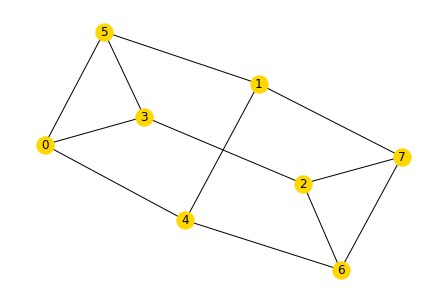

In [3]:
G = qcopt.graph_funcs.graph_from_file('benchmark_graphs/N8_d3_graphs/G1.txt')
nx.draw_spring(G, with_labels=True, node_color='gold')

In [5]:
new_circ = qcopt.dqva.gen_dqva(G, params=[1 for _ in range(G.number_of_nodes()+1)], barriers=2, decompose_toffoli=0)
new_circ.draw(fold=-1)

░           ░           ░           ░           ░           ░           ░ ┌───────┐ ░           ░  ░ ┌───────┐ ░  ░ 
q_0: ─░───────────░───────────░───────────░─────o─────░───────────░─────o─────░─┤ Rx(2) ├─░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░           ░           ░           ░     │     ░ ┌───────┐ ░     │     ░ └───┬───┘ ░     │     ░  ░ ├───────┤ ░  ░ 
q_1: ─░───────────░─────o─────░───────────░─────┼─────░─┤ Rx(2) ├─░─────o─────░─────┼─────░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░ ┌───────┐ ░     │     ░           ░     │     ░ └───┬───┘ ░     │     ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_2: ─░─┤ Rx(2) ├─░─────o─────░─────o─────░─────o─────░─────┼─────░─────┼─────░─────┼─────░─────┼─────░──░─┤ Rz(2) ├─░──░─
      ░ └───┬───┘ ░     │     ░     │     ░ ┌───┴───┐ ░     │     ░     │     ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_3: ─░─────o─────░─────┼─────░─────┼─────░─┤ Rx(2) ├─░─────┼─────░─────┼─────░─────o─────░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░     │     ░ └───┬───┘ ░     │     ░ ┌───┴───┐ ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_4: ─░─────┼─────░─────┼─────░─────o─────░─────┼─────░─────o─────░─┤ Rx(2) ├─░─────o─────░─────┼─────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░     │     ░     │     ░     │     ░ └───┬───┘ ░     │     ░ ┌───┴───┐ ░  ░ ├───────┤ ░  ░ 
q_5: ─░─────┼─────░─────┼─────░─────┼─────░─────o─────░─────o─────░─────┼─────░─────o─────░─┤ Rx(2) ├─░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░ ┌───┴───┐ ░           ░     │     ░     │     ░           ░ └───────┘ ░  ░ ├───────┤ ░  ░ 
q_6: ─░─────o─────░─────o─────░─┤ Rx(2) ├─░───────────░─────┼─────░─────o─────░───────────░───────────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░ ┌───┴───┐ ░ └───┬───┘ ░           ░     │     ░           ░           ░           ░  ░ ├───────┤ ░  ░ 
q_7: ─░─────o─────░─┤ Rx(2) ├─░─────o─────░───────────░─────o─────░───────────░───────────░───────────░──░─┤ Rz(2) ├─░──░─
      ░           ░ └───────┘ ░           ░           ░           ░           ░           ░           ░  ░ └───────┘ ░  ░

In [4]:
old_circ = qcopt.dqv_ancilla_ansatz.gen_dqva(G, params=[1 for _ in range(G.number_of_nodes()+1)], barriers=2, decompose_toffoli=0)
old_circ.draw(fold=-1)

░                     ░                     ░                     ░                     ░                     ░                     ░      ┌───────┐      ░                     ░  ░ ┌───────┐ ░  ░ 
q_0: ─░─────────────────────░─────────────────────░─────────────────────░───o─────────────o───░─────────────────────░───o─────────────o───░──────┤ Rx(2) ├──────░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
      ░                     ░                     ░                     ░   │             │   ░      ┌───────┐      ░   │             │   ░      └───┬───┘      ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_1: ─░─────────────────────░───o─────────────o───░─────────────────────░───┼─────────────┼───░──────┤ Rx(2) ├──────░───o─────────────o───░──────────┼──────────░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
      ░      ┌───────┐      ░   │             │   ░                     ░   │             │   ░      └───┬───┘      ░   │             │   ░          │          ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_2: ─░──────┤ Rx(2) ├──────░───o─────────────o───░───o─────────────o───░───o─────────────o───░──────────┼──────────░───┼─────────────┼───░──────────┼──────────░───┼─────────────┼───░──░─┤ Rz(2) ├─░──░─
      ░      └───┬───┘      ░   │             │   ░   │             │   ░   │  ┌───────┐  │   ░          │          ░   │             │   ░          │          ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_3: ─░───o──────┼──────o───░───┼─────────────┼───░───┼─────────────┼───░───┼──┤ Rx(2) ├──┼───░──────────┼──────────░───┼─────────────┼───░───o──────┼──────o───░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │             │   ░   │             │   ░   │  └───┬───┘  │   ░          │          ░   │  ┌───────┐  │   ░   │      │      │   ░   │             │   ░  ░ ├───────┤ ░  ░ 
q_4: ─░───┼──────┼──────┼───░───┼─────────────┼───░───o─────────────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░───o──────┼──────o───░───┼─────────────┼───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │             │   ░   │             │   ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │  ┌───────┐  │   ░  ░ ├───────┤ ░  ░ 
q_5: ─░───┼──────┼──────┼───░───┼─────────────┼───░───┼─────────────┼───░───o──────┼──────o───░───o──────┼──────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │             │   ░   │  ┌───────┐  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░  ░ ├───────┤ ░  ░ 
q_6: ─░───o──────┼──────o───░───o─────────────o───░───┼──┤ Rx(2) ├──┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ Rz(2) ├─░──░─
      ░   │      │      │   ░   │  ┌───────┐  │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░  ░ ├───────┤ ░  ░ 
q_7: ─░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░───o──────┼──────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ Rz(2) ├─░──░─
      ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐└───┬───┘┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░  ░ └───────┘ ░  ░ 
anc: ─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░──░───────────░──░─
      ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░  ░           ░  ░

#### QAO-Ansatz

In [9]:
p = 2
params = list(range(1,p * (len(G.nodes) + 1) + 1))
new_circ = qcopt.qaoa.gen_qaoa(G, p, params=params, barriers=2, decompose_toffoli=0, individual_partial_mixers=True)
new_circ.draw(fold=-1)

░ ┌───────┐ ░           ░           ░           ░            ░            ░            ░            ░  ░ ┌────────┐ ░ ┌────────┐ ░            ░            ░            ░            ░            ░            ░            ░  ░ ┌────────┐ ░ 
q_0: ─░─┤ Rx(2) ├─░───────────░───────────░─────o─────░─────o──────░─────o──────░────────────░────────────░──░─┤ Rz(18) ├─░─┤ Rx(20) ├─░────────────░────────────░─────o──────░─────o──────░─────o──────░────────────░────────────░──░─┤ Rz(36) ├─░─
      ░ └───┬───┘ ░ ┌───────┐ ░           ░     │     ░     │      ░     │      ░            ░            ░  ░ ├────────┤ ░ └───┬────┘ ░ ┌────────┐ ░            ░     │      ░     │      ░     │      ░            ░            ░  ░ ├────────┤ ░ 
q_1: ─░─────┼─────░─┤ Rx(4) ├─░───────────░─────┼─────░─────o──────░─────o──────░────────────░─────o──────░──░─┤ Rz(18) ├─░─────┼──────░─┤ Rx(22) ├─░────────────░─────┼──────░─────o──────░─────o──────░────────────░─────o──────░──░─┤ Rz(36) ├─░─
      ░     │     ░ └───┬───┘ ░ ┌───────┐ ░     │     ░     │      ░     │      ░            ░     │      ░  ░ ├────────┤ ░     │      ░ └───┬────┘ ░ ┌────────┐ ░     │      ░     │      ░     │      ░            ░     │      ░  ░ ├────────┤ ░ 
q_2: ─░─────┼─────░─────┼─────░─┤ Rx(6) ├─░─────o─────░─────┼──────░─────┼──────░─────o──────░─────o──────░──░─┤ Rz(18) ├─░─────┼──────░─────┼──────░─┤ Rx(24) ├─░─────o──────░─────┼──────░─────┼──────░─────o──────░─────o──────░──░─┤ Rz(36) ├─░─
      ░     │     ░     │     ░ └───┬───┘ ░ ┌───┴───┐ ░     │      ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░     │      ░     │      ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░ 
q_3: ─░─────o─────░─────┼─────░─────o─────░─┤ Rx(8) ├─░─────┼──────░─────o──────░─────┼──────░─────┼──────░──░─┤ Rz(18) ├─░─────o──────░─────┼──────░─────o──────░─┤ Rx(26) ├─░─────┼──────░─────o──────░─────┼──────░─────┼──────░──░─┤ Rz(36) ├─░─
      ░     │     ░     │     ░     │     ░ └───┬───┘ ░ ┌───┴────┐ ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░     │      ░     │      ░     │      ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░     │      ░  ░ ├────────┤ ░ 
q_4: ─░─────o─────░─────o─────░─────┼─────░─────┼─────░─┤ Rx(10) ├─░─────┼──────░─────o──────░─────┼──────░──░─┤ Rz(18) ├─░─────o──────░─────o──────░─────┼──────░─────┼──────░─┤ Rx(28) ├─░─────┼──────░─────o──────░─────┼──────░──░─┤ Rz(36) ├─░─
      ░     │     ░     │     ░     │     ░     │     ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░  ░ ├────────┤ ░     │      ░     │      ░     │      ░     │      ░ └───┬────┘ ░ ┌───┴────┐ ░     │      ░     │      ░  ░ ├────────┤ ░ 
q_5: ─░─────o─────░─────o─────░─────┼─────░─────o─────░─────┼──────░─┤ Rx(12) ├─░─────┼──────░─────┼──────░──░─┤ Rz(18) ├─░─────o──────░─────o──────░─────┼──────░─────o──────░─────┼──────░─┤ Rx(30) ├─░─────┼──────░─────┼──────░──░─┤ Rz(36) ├─░─
      ░           ░     │     ░     │     ░           ░     │      ░ └────────┘ ░ ┌───┴────┐ ░     │      ░  ░ ├────────┤ ░            ░     │      ░     │      ░            ░     │      ░ └────────┘ ░ ┌───┴────┐ ░     │      ░  ░ ├────────┤ ░ 
q_6: ─░───────────░─────┼─────░─────o─────░───────────░─────o──────░────────────░─┤ Rx(14) ├─░─────o──────░──░─┤ Rz(18) ├─░────────────░─────┼──────░─────o──────░────────────░─────o──────░────────────░─┤ Rx(32) ├─░─────o──────░──░─┤ Rz(36) ├─░─
      ░           ░     │     ░     │     ░           ░            ░            ░ └───┬────┘ ░ ┌───┴────┐ ░  ░ ├────────┤ ░            ░     │      ░     │      ░            ░            ░            ░ └───┬────┘ ░ ┌───┴────┐ ░  ░ ├────────┤ ░ 
q_7: ─░───────────░─────o─────░─────o─────░───────────░────────────░────────────░─────o──────░─┤ Rx(16) ├─░──░─┤ Rz(18) ├─░────────────░─────o──────░─────o──────░────────────░────────────░────────────░─────o──────░─┤ Rx(34) ├─░──░─┤ Rz(36) ├─░─
      ░           ░           ░           ░           ░            ░            ░     

In [ ]:
old_circ = qcopt.qao_ancilla_ansatz.gen_qaoa(G, p, params=[1]*(2*p), barriers=2, decompose_toffoli=0)
old_circ.draw(fold=-1)